In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


採点時点：2023年1月5日15時   This score is on the Public Leaderboard.
0.75173

In [ ]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/My Drive/Colab Notebooks/GCIcompetition2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/GCIcompetition2


In [ ]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "./input/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

In [ ]:
train["Is_train"] = 1
test["Is_train"] = 0
data = pd.concat([train, test])

In [ ]:
pd.set_option('display.max_columns', 1000)

In [ ]:
data["FLAG_OWN_CAR"].unique()

array(['N', 'Y', nan], dtype=object)

In [ ]:
data.isnull().sum()

SK_ID_CURR                          0
TARGET                          61500
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                    46575
FLAG_OWN_REALTY                 46575
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                         9
AMT_GOODS_PRICE                   216
NAME_TYPE_SUITE                   995
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OWN_CAR_AGE                    153901
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE  

In [ ]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Is_train
0,0,0.0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN,1
1,1,0.0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0,1
2,2,0.0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN,1
3,3,0.0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4,1.0,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0,1


In [ ]:
#SK_ID_CURRがいらないので削除
data.drop('SK_ID_CURR', axis=1, inplace=True)

In [ ]:
data['DAYS_EMPLOYED'].replace(0, 1, inplace= True)
#0で割らないため

In [ ]:
data["OWN_CAR_AGE"]
data.loc[data["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
data["OWN_CAR_AGE"] = data["OWN_CAR_AGE"] // 10
data["OWN_CAR_AGE"].unique()
car_age_ohe = pd.get_dummies(data["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
data = pd.concat([data, car_age_ohe], axis=1)
data.drop('OWN_CAR_AGE', axis=1, inplace=True)

In [ ]:
docs = [_f for _f in data.columns if 'FLAG_DOC' in _f]
live = [_f for _f in data.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]

data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

inc_by_org = data[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

data['NEW_CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['NEW_CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
data['NEW_LIVE_IND_SUM'] = data[live].sum(axis=1)
data['NEW_LIVE_IND_STD'] = data[live].std(axis=1)
data['NEW_LIVE_IND_KURT'] = data[live].kurtosis(axis=1)
data['NEW_INC_PER_CHLD'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])
data['NEW_INC_BY_ORG'] = data['ORGANIZATION_TYPE'].map(inc_by_org)
data['NEW_EMPLOY_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['NEW_ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / (1 + data['AMT_INCOME_TOTAL'])
data['NEW_EXT_SOURCES_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
data['NEW_SCORES_STD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
data['NEW_SCORES_STD'] = data['NEW_SCORES_STD'].fillna(data['NEW_SCORES_STD'].mean())

data['NEW_PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']
data['NEW_PHONE_TO_EMPLOY_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_EMPLOYED']
data['NEW_CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']

NAME_CONTRACT_TYPE 2値　そのまま
CODE_GENDER　わずかに欠損値ある
data["FLAG_OWN_CAR"] 欠損値たくさん 46000件
FLAG_OWN_REALTY                 46575


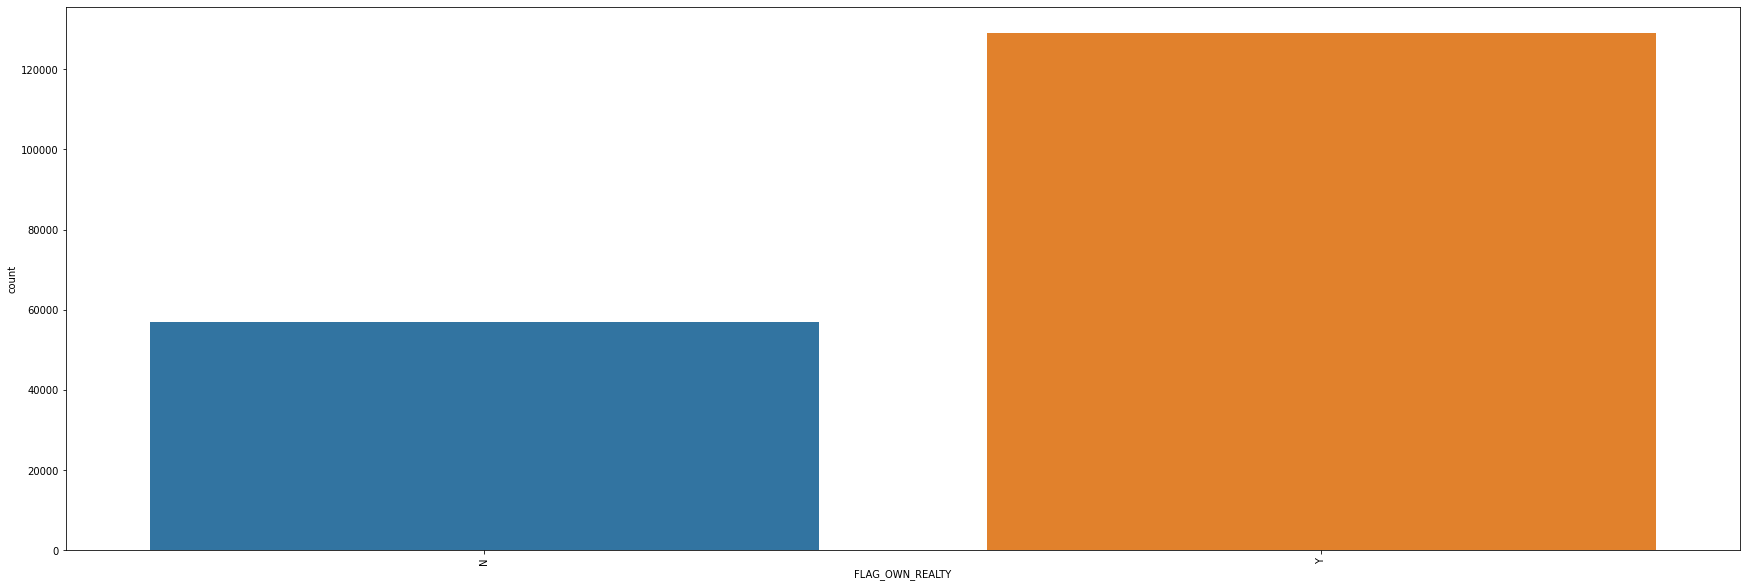

In [ ]:
plt.figure(figsize=(30, 10))
sns.countplot(data=data, x="FLAG_OWN_REALTY")
plt.tick_params(axis="x", rotation=90)
plt.show()

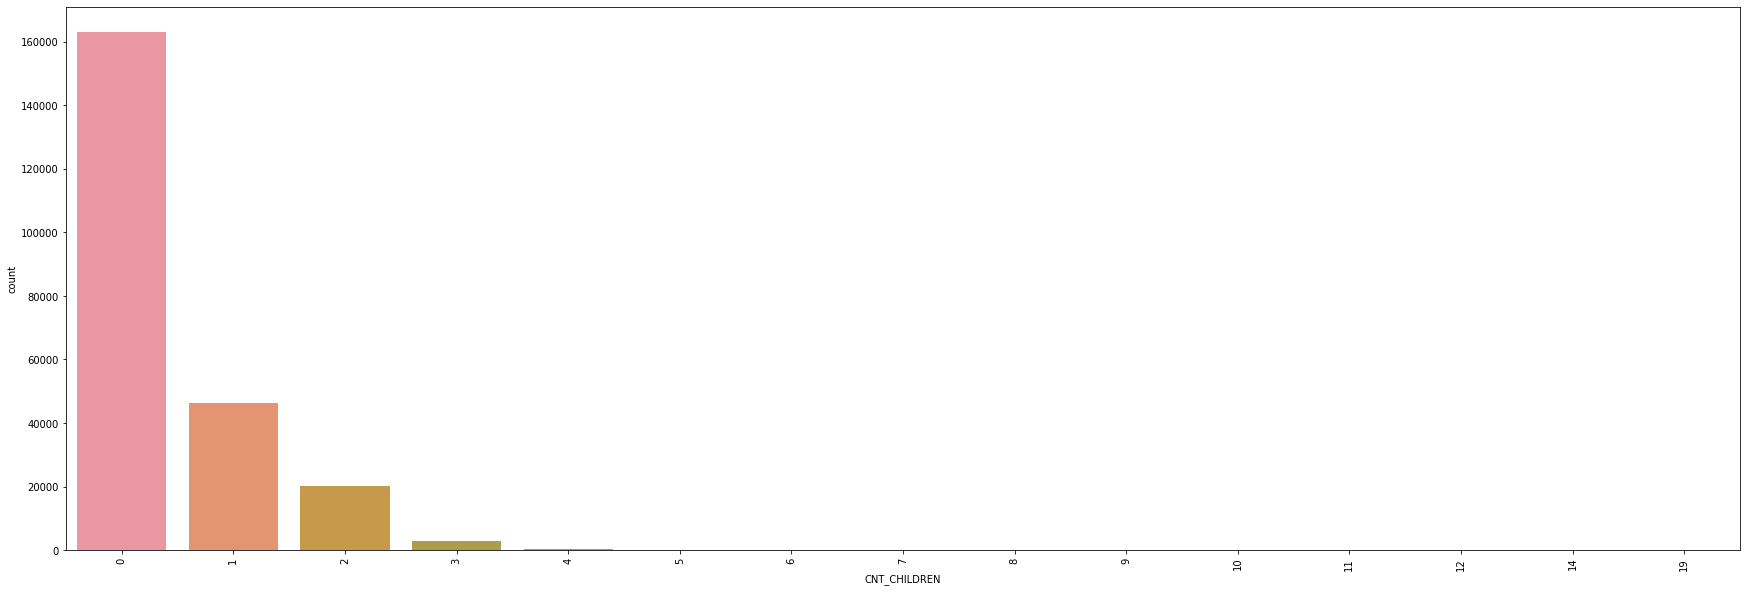

array([ 0,  1,  2,  3,  4,  6,  5,  7,  9, 10, 12,  8, 14, 11, 19])

In [ ]:
plt.figure(figsize=(30, 10))
sns.countplot(data=data, x="CNT_CHILDREN")
plt.tick_params(axis="x", rotation=90)
plt.show()
data["CNT_CHILDREN"].unique()

In [ ]:
#５人以上は間違いだろうから0にしていいと思う

In [ ]:
rep = data["CNT_CHILDREN"].replace([6,  5,  7,  9, 10, 12,  8, 14, 11, 19], 0)
rep.unique()
data["CNT_CHILDREN"] = rep

In [ ]:
data_CNT_CHILDREN = pd.get_dummies(data["CNT_CHILDREN"], prefix = "CNT_CHILDREN")
data = pd.concat([data, data_CNT_CHILDREN], axis=1)
data.drop("CNT_CHILDREN", axis=1, inplace=True)
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Is_train,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_LIVE_IND_SUM,NEW_LIVE_IND_STD,NEW_LIVE_IND_KURT,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,NEW_CREDIT_TO_INCOME_RATIO,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_3,CNT_CHILDREN_4
0,0.0,Cash loans,F,N,N,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878.0,-333.0,-522,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,20.787811,1.118800,4,0.516398,-1.875000,112500.0,135000.0,0.095094,0.322917,0.372591,0.149274,0.031626,0.332574,6.712800,1,0,0,0,0
1,0.0,Cash loans,F,N,Y,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,NaN,-4469.0,-3436,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0,1,0,0,0,0,0,0,34.629728,1.000000,2,0.516398,-1.875000,225000.0,117000.0,NaN,0.075080,0.501366,0.073255,0.030623,NaN,2.600000,1,0,0,0,0
2,0.0,Cash loans,F,N,Y,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523.0,-3640.0,-2050,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,18.303180,1.237600,5,0.408248,6.000000,54000.0,112500.0,0.028276,0.338077,0.569503,0.149274,0.029304,1.036329,6.188000,1,0,0,0,0
3,0.0,Cash loans,F,N,Y,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,NaN,-4950.0,-3951,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,17.168857,1.132000,3,0.547723,-3.333333,67500.0,117000.0,NaN,0.131865,0.436379,0.468309,-0.000000,NaN,2.264000,1,0,0,0,0
4,1.0,Cash loans,M,N,N,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697.0,-5101.0,-3226,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0,1,0,0,0,0,0,0,12.580827,1.158404,4,0.516398,-1.875000,157500.0,157500.0,0.065232,0.136799,0.404630,0.239439,0.116331,1.783357,1.721057,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61495,NaN,Cash loans,F,Y,Y,315000.0,1288350.0,37800.0,1125000.0,Family,Commercial associate,Higher education,Married,House / apartment,0.007020,-11430,-792.0,-9772.0,-2705,1,1,0,1,0,0,Managers,2.0,2,2,0,0,0,0,0,0,Trade: type 7,0.263678,0.01

In [ ]:
"""for i in range(len(data.columns)):
    colu = data.columns[i]
    if len(data[colu].unique()) < 5:
        plt.figure(figsize=(30, 10))
        sns.countplot(data=data, x=colu)
        plt.tick_params(axis="x", rotation=90)
        plt.show()
        print(data[colu].unique())"""

'for i in range(len(data.columns)):\n    colu = data.columns[i]\n    if len(data[colu].unique()) < 5:\n        plt.figure(figsize=(30, 10))\n        sns.countplot(data=data, x=colu)\n        plt.tick_params(axis="x", rotation=90)\n        plt.show()\n        print(data[colu].unique())'

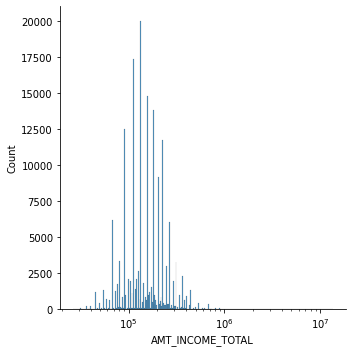

In [ ]:
# AMT_INCOME_TOTALの分布（対数変換）
sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
plt.show()

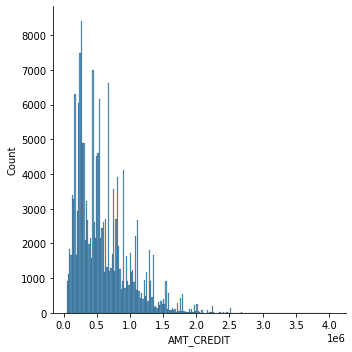

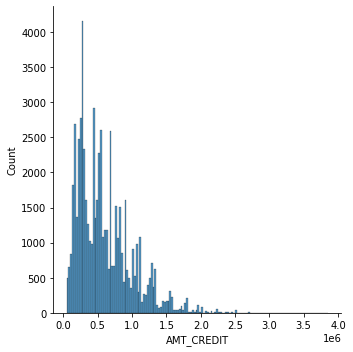

In [ ]:
# AMT_INCOME_TOTALの分布
sns.displot(data=train, x="AMT_CREDIT")
plt.show()
sns.displot(data=test, x="AMT_CREDIT")
plt.show()

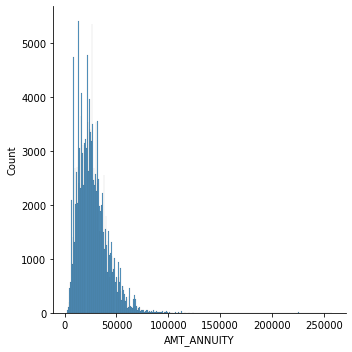

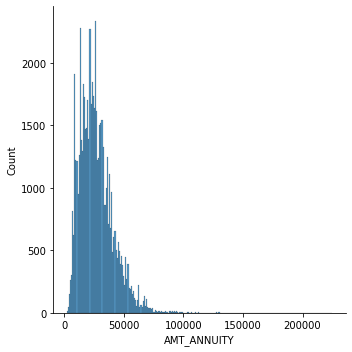

In [ ]:
# AMT_INCOME_TOTALの分布
sns.displot(data=train, x="AMT_ANNUITY")
plt.show()
sns.displot(data=test, x="AMT_ANNUITY")
plt.show()

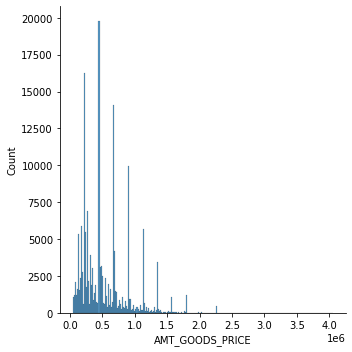

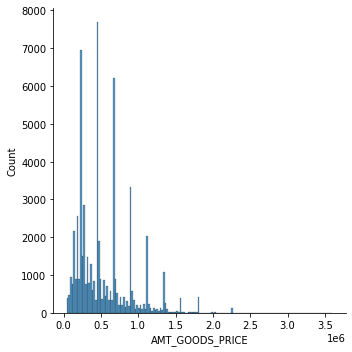

In [ ]:
# AMT_INCOME_TOTALの分布
sns.displot(data=train, x="AMT_GOODS_PRICE")
plt.show()
sns.displot(data=test, x="AMT_GOODS_PRICE")
plt.show()

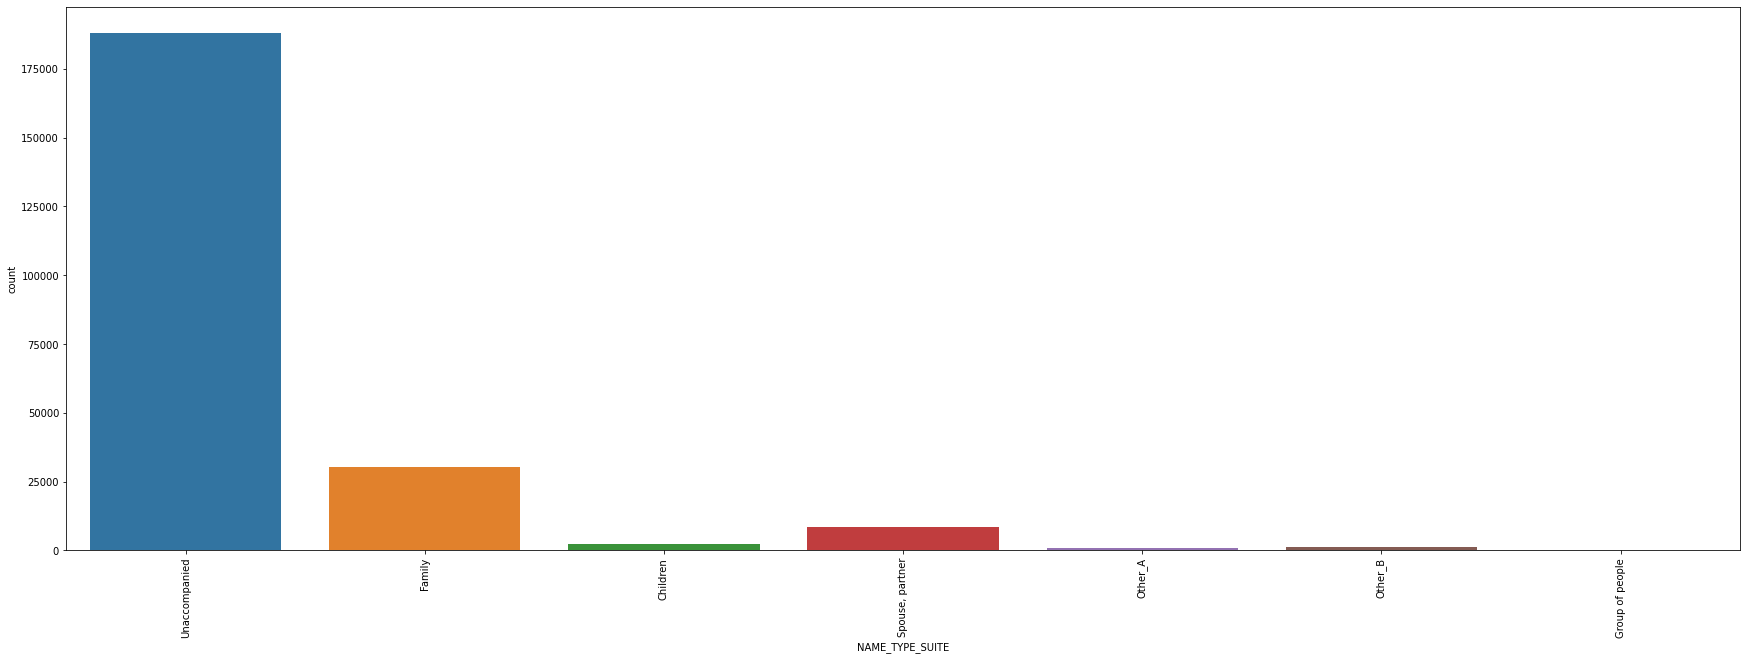

array(['Unaccompanied', 'Family', 'Children', 'Spouse, partner', nan,
       'Other_A', 'Other_B', 'Group of people'], dtype=object)

In [ ]:
plt.figure(figsize=(30, 10))
sns.countplot(data=data, x="NAME_TYPE_SUITE")
plt.tick_params(axis="x", rotation=90)
plt.show()
data["NAME_TYPE_SUITE"].unique()

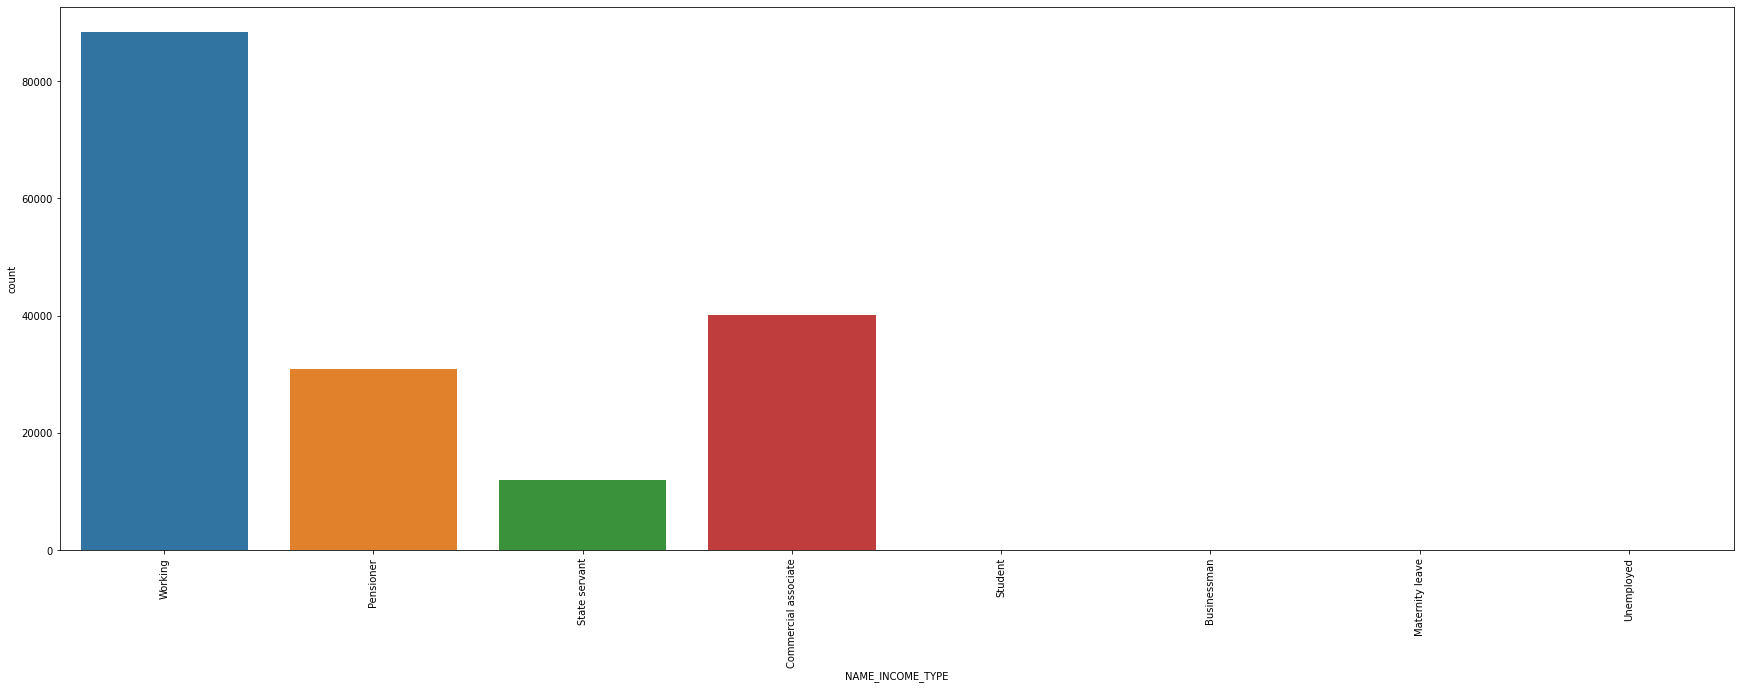

array(['Working', 'Pensioner', 'State servant', 'Commercial associate',
       'Student', 'Businessman', 'Maternity leave', 'Unemployed'],
      dtype=object)

In [ ]:
# ORGANIZATION_TYPEの分布
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="NAME_INCOME_TYPE")
plt.tick_params(axis="x", rotation=90)
plt.show()
data["NAME_INCOME_TYPE"].unique()

In [ ]:
#少ないものはその他に入れる
rep = data["NAME_INCOME_TYPE"].replace(['Student', 'Businessman', 'Maternity leave', 'Unemployed'], "other")
data["CNT_CHILDREN"] = rep

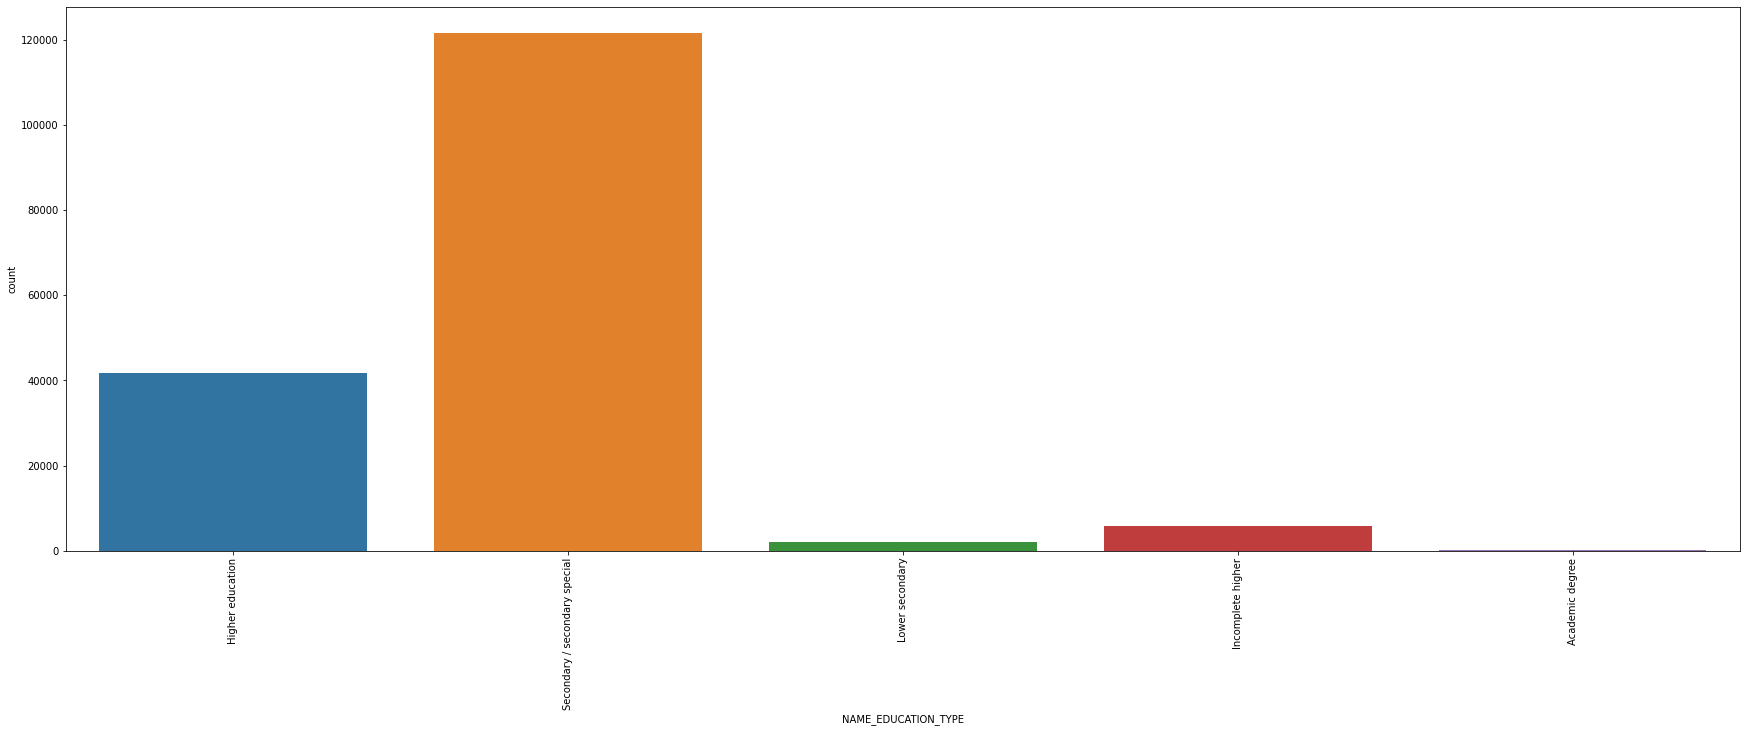

In [ ]:
# ORGANIZATION_TYPEの分布
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="NAME_EDUCATION_TYPE")
plt.tick_params(axis="x", rotation=90)
plt.show()

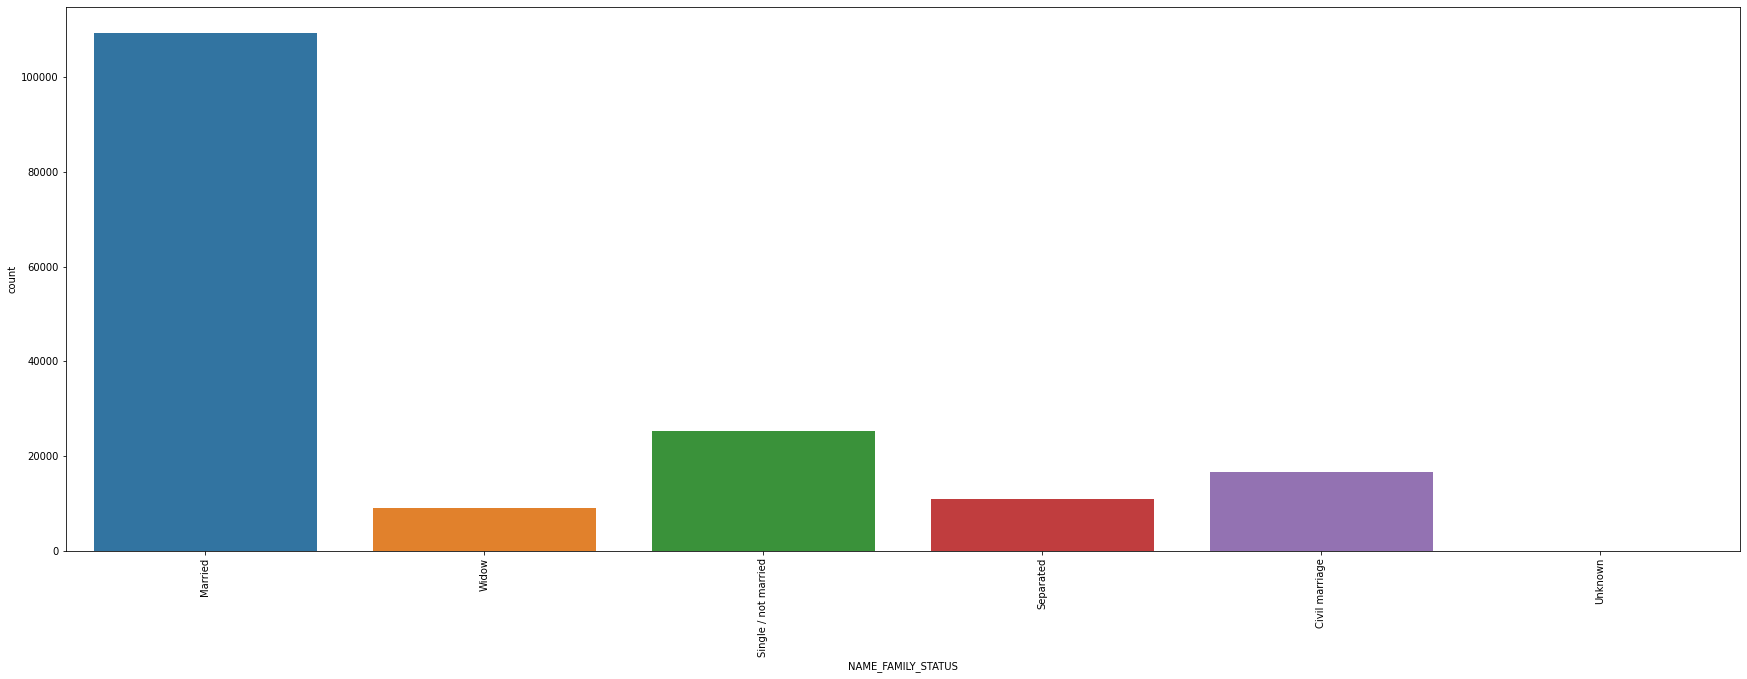

In [ ]:
# ORGANIZATION_TYPEの分布
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="NAME_FAMILY_STATUS")
plt.tick_params(axis="x", rotation=90)
plt.show()

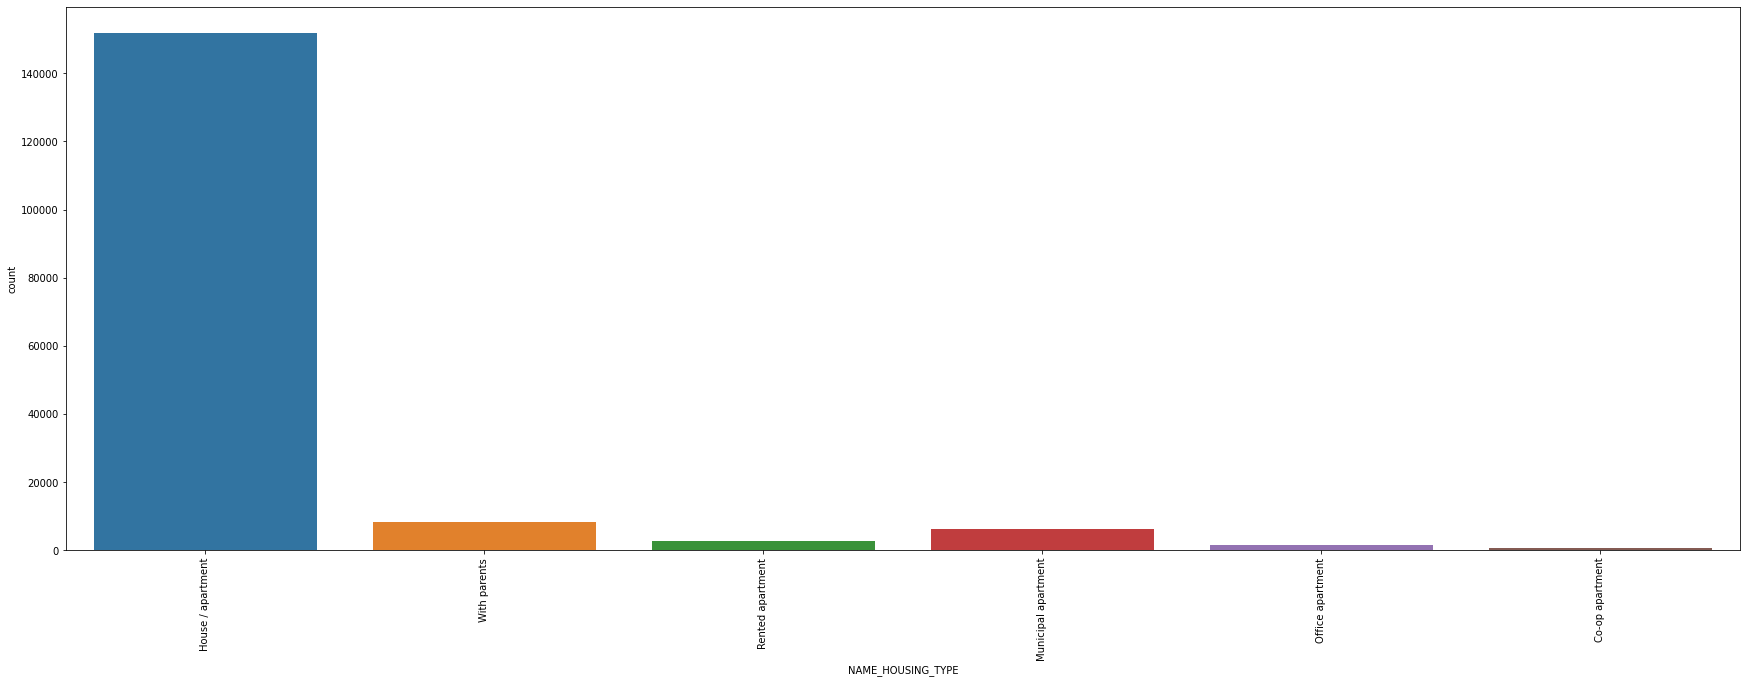

In [ ]:
# ORGANIZATION_TYPEの分布
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="NAME_HOUSING_TYPE")
plt.tick_params(axis="x", rotation=90)
plt.show()

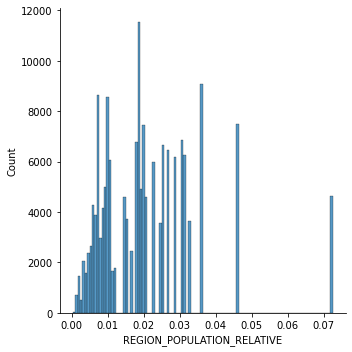

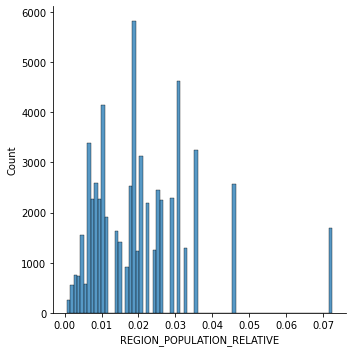

0        0.010032
1        0.008019
2        0.004960
3        0.005002
4        0.006296
           ...   
61495    0.007020
61496    0.006671
61497    0.018801
61498    0.002042
61499    0.022625
Name: REGION_POPULATION_RELATIVE, Length: 232702, dtype: float64

In [ ]:
# ORGANIZATION_TYPEの分布
sns.displot(data=train, x="REGION_POPULATION_RELATIVE")
plt.show()
sns.displot(data=test, x="REGION_POPULATION_RELATIVE")
plt.show()
data["REGION_POPULATION_RELATIVE"]

#クライアントが住んでいる地域の正規化された集団（より高い数は、クライアントがより人口の多い地域に住んでいることを意味します）

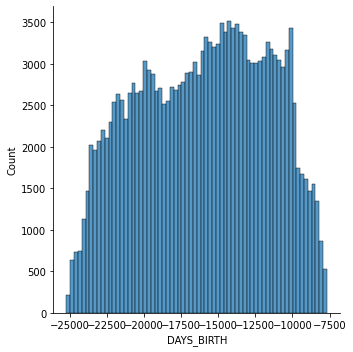

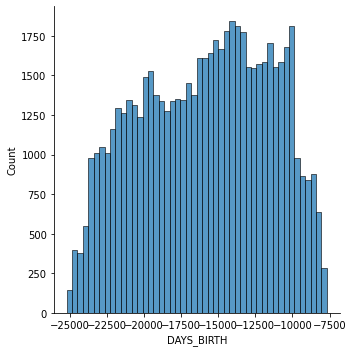

0        -9233
1       -20148
2       -18496
3       -24177
4       -10685
         ...  
61495   -11430
61496   -17181
61497   -14515
61498   -16914
61499    -9799
Name: DAYS_BIRTH, Length: 232702, dtype: int64

In [ ]:
sns.displot(data=train, x="DAYS_BIRTH")
plt.show()
sns.displot(data=test, x="DAYS_BIRTH")
plt.show()
data["DAYS_BIRTH"]
#なんかマイナスになってる
#細かい分布に意味があると思えないので、5つくらいのbinに分けようと思う

In [ ]:
data.isnull().sum()

TARGET                61500
NAME_CONTRACT_TYPE        0
CODE_GENDER               0
FLAG_OWN_CAR          46575
FLAG_OWN_REALTY       46575
                      ...  
CNT_CHILDREN_1            0
CNT_CHILDREN_2            0
CNT_CHILDREN_3            0
CNT_CHILDREN_4            0
CNT_CHILDREN              0
Length: 75, dtype: int64

In [ ]:
# EXT_SOURCE_2の欠損値を平均値で補完
data["EXT_SOURCE_1"].fillna(data["EXT_SOURCE_1"].mean(), inplace=True)
data["EXT_SOURCE_2"].fillna(data["EXT_SOURCE_2"].mean(), inplace=True)
data["EXT_SOURCE_3"].fillna(data["EXT_SOURCE_3"].mean(), inplace=True)
data.info()
data["DAYS_LAST_PHONE_CHANGE"].fillna(data["DAYS_LAST_PHONE_CHANGE"].mean(), inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232702 entries, 0 to 61499
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       171202 non-null  float64
 1   NAME_CONTRACT_TYPE           232702 non-null  object 
 2   CODE_GENDER                  232702 non-null  object 
 3   FLAG_OWN_CAR                 186127 non-null  object 
 4   FLAG_OWN_REALTY              186127 non-null  object 
 5   AMT_INCOME_TOTAL             232702 non-null  float64
 6   AMT_CREDIT                   232702 non-null  float64
 7   AMT_ANNUITY                  232693 non-null  float64
 8   AMT_GOODS_PRICE              232486 non-null  float64
 9   NAME_TYPE_SUITE              231707 non-null  object 
 10  NAME_INCOME_TYPE             232702 non-null  object 
 11  NAME_EDUCATION_TYPE          232702 non-null  object 
 12  NAME_FAMILY_STATUS           232702 non-null  object 
 13  

In [ ]:
# Some simple new features (percentages)
data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']

In [ ]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    data[bin_feature], uniques = pd.factorize(data[bin_feature])

In [ ]:
# One-hot encoding for categorical columns with get_dummies
original_columns = list(data.columns)
categorical_columns = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data, columns= categorical_columns, dummy_na= True)
"""new_columns = [c for c in data.columns if c not in original_columns]

#data, cat_cols = one_hot_encoder(data, nan_as_category)
new_columns"""
data.drop_duplicates()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Is_train,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_LIVE_IND_SUM,NEW_LIVE_IND_STD,NEW_LIVE_IND_KURT,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,NEW_CREDIT_TO_INCOME_RATIO,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_3,CNT_CHILDREN_4,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION

In [ ]:
data

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Is_train,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_LIVE_IND_SUM,NEW_LIVE_IND_STD,NEW_LIVE_IND_KURT,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,NEW_CREDIT_TO_INCOME_RATIO,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_3,CNT_CHILDREN_4,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232702 entries, 0 to 61499
Columns: 195 entries, TARGET to CNT_CHILDREN_nan
dtypes: float64(39), int64(21), uint8(135)
memory usage: 146.3 MB


In [ ]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [ ]:
# 目的変数と説明変数に分割
train = data[data["Is_train"] == 1]
test =  data[data["Is_train"] == 0]

#Istrainを消す
train.drop("Is_train", axis=1, inplace=True)
test.drop("Is_train", axis=1, inplace=True)

In [ ]:
print(train.info())
print(test.info())
train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171202 entries, 0 to 171201
Columns: 194 entries, TARGET to CNT_CHILDREN_nan
dtypes: float64(39), int64(20), uint8(135)
memory usage: 100.4 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61500 entries, 0 to 61499
Columns: 194 entries, TARGET to CNT_CHILDREN_nan
dtypes: float64(39), int64(20), uint8(135)
memory usage: 36.1 MB
None


,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_LIVE_IND_SUM,NEW_LIVE_IND_STD,NEW_LIVE_IND_KURT,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,NEW_CREDIT_TO_INCOME_RATIO,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_3,CNT_CHILDREN_4,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Ins

In [ ]:
data.isnull().sum().head(50)

TARGET                         61500
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        9
AMT_GOODS_PRICE                  216
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                  41463
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
CNT_FAM_MEMBERS                    2
REGION_RATING_CLIENT               0
REGION_RATING_CLIENT_W_CITY        0
REG_REGION_NOT_LIVE_REGION         0
REG_REGION_NOT_WORK_REGION         0
LIVE_REGION_NOT_WORK_REGION        0
REG_CITY_NOT_LIVE_CITY             0
REG_CITY_NOT_WORK_CITY             0
L

In [ ]:
pd.set_option('display.max_columns', 4096)
train.head(30)

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_LIVE_IND_SUM,NEW_LIVE_IND_STD,NEW_LIVE_IND_KURT,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,NEW_CREDIT_TO_INCOME_RATIO,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_3,CNT_CHILDREN_4,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Ins

いらない　"SK_ID_CURR",


In [ ]:
test

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_LIVE_IND_SUM,NEW_LIVE_IND_STD,NEW_LIVE_IND_KURT,NEW_INC_PER_CHLD,NEW_INC_BY_ORG,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_EXT_SOURCES_MEAN,NEW_SCORES_STD,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,NEW_CREDIT_TO_INCOME_RATIO,CNT_CHILDREN_0,CNT_CHILDREN_1,CNT_CHILDREN_2,CNT_CHILDREN_3,CNT_CHILDREN_4,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Ins

In [ ]:
X = train.drop("TARGET", axis=1).values
test.drop("TARGET", axis=1, inplace = True)
y = train["TARGET"].values

X_test = test.values
print(np.ndim(X))
print(np.ndim(y))
print(np.ndim(X_test))
X_test

2
1
2


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.]])

In [ ]:
# 標準化
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
X_test_std = sc.transform(X_test)

In [ ]:
# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [ ]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth = 3,  # the maximum depth of each tree
    eta = 0.3,  # the training step for each iteration
    silent = 1,  # logging mode - quiet
    objective= "multi:softprob",  # error evaluation for multiclass training
    num_class = 3)  # the number of classes that exist in this datset)
xgb.fit(X_train, y_train)

xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, xgb_valid_pred)}")

Train Score: 0.7639093449814353
Valid Score: 0.7496159479026137


In [ ]:
# LGBMClassifier
from lightgbm import LGBMClassifier
seed = 42

lgb = LGBMClassifier(nthread=4,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

Train Score: 0.7628794770175578
Valid Score: 0.7419950198563611


In [ ]:
train_pred = (lgb_train_pred + xgb_train_pred)/2
valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)}")

Train Score: 0.7648987299926665
Valid Score: 0.7474919438176779


In [ ]:
# テストデータに対する予測値の作成
pred = xgb.predict_proba(X_test)[:, 1]

In [ ]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.035391
1,171203,0.229619
2,171204,0.159264
3,171205,0.113631
4,171206,0.186844
...,...,...
61495,232697,0.189057
61496,232698,0.040260
61497,232699,0.054798
61498,232700,0.119420


In [ ]:
# 提出用のcsvファイルを作成
sample_sub.to_csv('submission.csv',index=False)

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features
https://www.kaggle.com/code/ogrellier/lighgbm-with-selected-features